In [1]:
%matplotlib notebook

In [2]:
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import IntSlider, interact
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm

## Loading the data

(requirement #1)

In [3]:
name = '/Users/busko/Dropbox/NGC5406.V1200.rscube.fits'
hdulist = fits.open(name)
if len(hdulist)>1:
    hdu=hdulist[1]
else:
    hdu=hdulist[0]

raw_cube = hdu.data.T # remember to always transpose with fits files
cube = raw_cube[20:60,20:60,:] # data seems to have garbage at the edges.
hdr = hdu.header

hdr['CRVAL3'] = 0 # adapt to this data
hdr['Cd3_3'] = 1

## Calculate the median map

In [4]:
median = np.median(cube, axis=2)

## Display cube, median map, and spectra

(requirements #2 and #3)

<IPython.core.display.Javascript object>


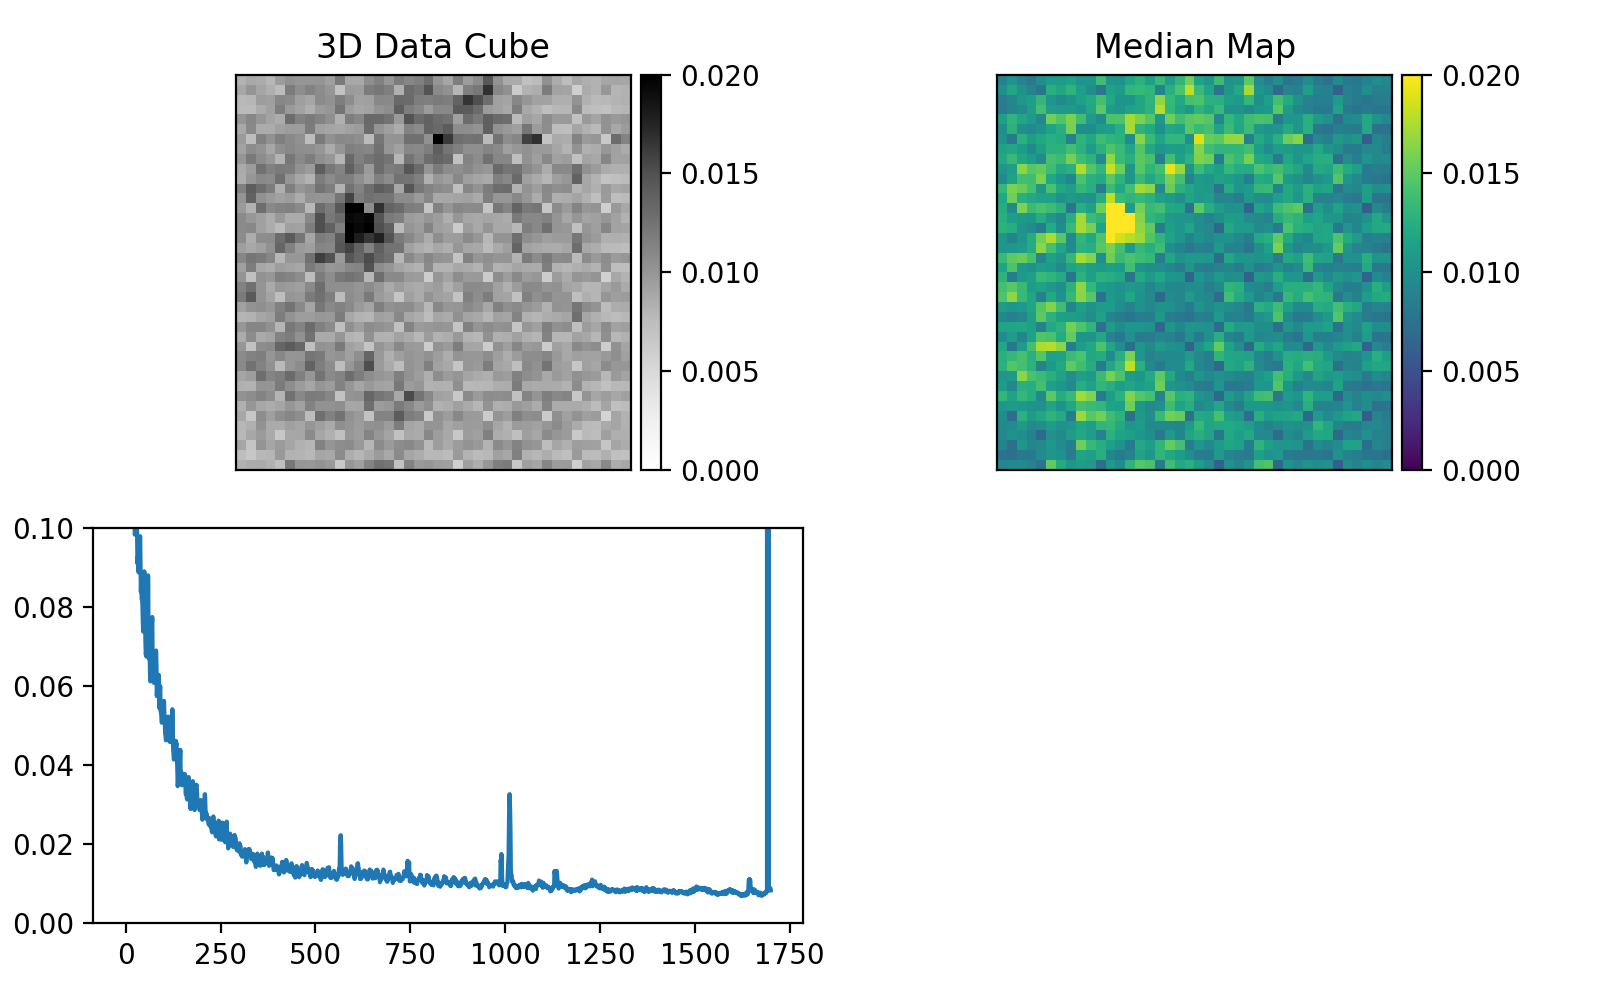

interactive(children=(IntSlider(value=850, description='slice_num', max=1700), Output()), _dom_classes=('widge…

In [5]:
# Create the slider
slider = IntSlider(
    value=int(cube.shape[2]/2.),
    min=0,
    max=cube.shape[2]-1)

# Create figure and axes
fig_cube = plt.figure(figsize=(8,5))
ax_cube = fig_cube.add_subplot(221)
ax_median = fig_cube.add_subplot(222)
ax_plot = fig_cube.add_subplot(223)

ax_cube.set_xticks([])
ax_cube.set_yticks([])
ax_median.set_xticks([])
ax_median.set_yticks([])
ax_cube.set_title('3D Data Cube')
ax_median.set_title('Median Map')

# Display the raw cube and median maps
median_im = ax_median.imshow(median, vmin=0.,vmax=0.02)
divider = make_axes_locatable(ax_median)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig_cube.colorbar(median_im, cax=cax)

cube_im = ax_cube.imshow(cube[:,:,0],vmin=0.,vmax=0.02,cmap=cm.get_cmap('Greys'))
divider = make_axes_locatable(ax_cube)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig_cube.colorbar(cube_im, cax=cax)

plt.tight_layout()

# Callback for the slice slider for the cube
def plot_test(slice_num):
    cube_im.set_data(cube[:,:,slice_num])
    fig_cube.canvas.draw()

ax_plot.set_ylim([0.0,0.1])
ax_plot.plot(cube[20,20,:])

_ = interact(plot_test, slice_num=slider)